In [20]:
import pandas as pd
import os
import numpy as np
import sys
sys.path.append('..')

In [76]:
data = pd.read_csv('../data/interim/eq_2.csv')

In [77]:
data.columns

Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'legal_ownership_status',
       'count_families', 'damage_grade'],
      dtype='object')

In [155]:
numerical_df = data.select_dtypes(exclude=['object'])
numerical_df.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,count_families,damage_grade,old
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,21.656229,8.018051,5.434365,0.088645,0.761935,0.075268,0.254988,0.042590,0.015859,0.983949,2.238272,0.013384
std,8.033617,412.710734,3646.369645,0.727665,19.800349,4.392231,1.918418,0.284231,0.425900,0.263824,0.435855,0.201931,0.124932,0.418389,0.611814,0.114915
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,100.000000,100.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,3.000000,1.000000


In [157]:
from scipy.stats import skew

def get_right_skewed_columns(df, skew_threshold=0.5):
    """
    Returns the names of columns that are right-skewed based on the skewness value, excluding binary columns.
    
    Parameters:
    - df: The input DataFrame (numerical columns only).
    - skew_threshold: The skewness threshold above which a column is considered right-skewed (default is 0.5).
    
    Returns:
    - List of column names that are right-skewed.
    """
    right_skewed_columns = []
    
    # Iterate through each column in the dataframe
    for col in df.columns:
        # Check if the column has more than 2 unique values (to avoid binary columns)
        if df[col].nunique() > 2:
            # Calculate skewness for each column
            col_skewness = skew(df[col].dropna())  # Drop NaN values to avoid issues
            
            # Check if the skewness is above the specified threshold (indicating right-skewness)
            if col_skewness > skew_threshold:
                right_skewed_columns.append(col)
    
    return right_skewed_columns


In [159]:
# Select numerical columns
numerical_df = data.select_dtypes(exclude=['object'])

# Get the right-skewed columns
right_skewed_cols = get_right_skewed_columns(numerical_df)

print("Right-skewed columns:", right_skewed_cols)


Right-skewed columns: ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']


In [206]:
import numpy as np

def apply_log_transformation(df, columns):
    """
    Applies log transformation to the specified columns of the DataFrame.
    
    Parameters:
    - df: The input DataFrame.
    - columns: List of column names to apply the log transformation on.
    
    Returns:
    - DataFrame with log-transformed columns.
    """
    
    df_transformed = df.copy()
    
    # Apply log transformation to each specified column
    for col in columns:
        # Add a small constant to avoid log(0) and handle any zeros or negatives
        df_transformed[col] = np.log(df[col])
    
    return df_transformed


In [255]:
# Get the right-skewed columns (excluding binary columns)
right_skewed_cols = get_right_skewed_columns(numerical_df)
numerical_df = apply_log_transformation(numerical_df, right_skewed_cols)
data[right_skewed_cols] = numerical_df[right_skewed_cols]

In [257]:
#pct = np.percentile(data.loc[:, 'age'].fillna(np.mean(data.loc[:, 'age'])), 99)
#print(pct)
#print(data.shape)
#data = data.loc[data.loc[:, 'age'] < pct]
#print(data.shape)

In [259]:
# Calculate the 99th percentile of the 'age' column
pct = np.percentile(data.loc[:, 'age'].fillna(np.mean(data.loc[:, 'age'])), 99)
print(pct)

# Add a new column 'old' to indicate if the age exceeds the 99th percentile
data['old'] = np.where(data['age'] >= pct, 1, 0)

# Cap the age to 100 where 'old' column is 1
data.loc[data['old'] == 1, 'age'] = 100

print(data.head())

100.0
   geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  age  \
0               6             487           12198                    2   30   
1               8             900            2812                    2   10   
2              21             363            8973                    2   10   
3              22             418           10694                    2   10   
4              11             131            1488                    3   30   

   area_percentage  height_percentage land_surface_condition foundation_type  \
0                6                  5                      t               r   
1                8                  7                      o               r   
2                5                  5                      t               r   
3                6                  5                      t               r   
4                8                  9                      t               r   

  roof_type  ... has_superstructure_ad

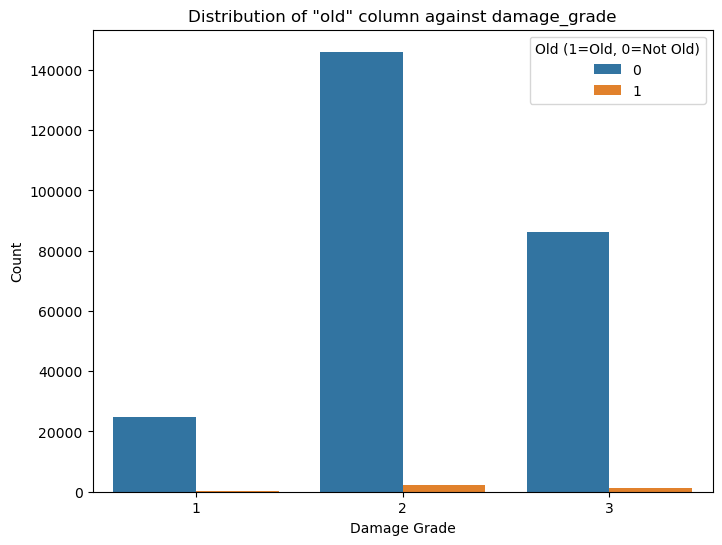

In [261]:
import matplotlib.pyplot as plt
import seaborn as sns
# Count the occurrences of 'old' against the target variable 'damage_grade'
plot_data = data.groupby(['old', 'damage_grade']).size().reset_index(name='counts')

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='damage_grade', y='counts', hue='old', data=plot_data)

# Add labels and title
plt.title('Distribution of "old" column against damage_grade')
plt.xlabel('Damage Grade')
plt.ylabel('Count')
plt.legend(title="Old (1=Old, 0=Not Old)")

# Show the plot
plt.show()

In [262]:
x = data.drop(columns=['damage_grade'])
y = data.damage_grade

In [266]:
y = y.replace({1: 0, 2: 1, 3: 2})

In [268]:
y

0         2
1         1
2         2
3         1
4         2
         ..
260596    1
260597    2
260598    2
260599    1
260600    2
Name: damage_grade, Length: 260601, dtype: int64

In [270]:
y.value_counts()

damage_grade
1    148259
2     87218
0     25124
Name: count, dtype: int64

In [272]:
x.old.value_counts()

old
0    257113
1      3488
Name: count, dtype: int64

In [274]:
#numerical_df = data.select_dtypes(exclude=['object'])
#categorical_df = data.select_dtypes(include=['object'])

In [276]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in x.columns if  x[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in x.columns if x[cname].dtype in ['int32', 'int64', 'float64']]

In [278]:
categorical_cols

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status']

(array([26041.,     0.,     0., 33697.,     0., 38896., 68192., 53104.,
        28172., 12499.]),
 array([0.        , 0.46151205, 0.9230241 , 1.38453616, 1.84604821,
        2.30756026, 2.76907231, 3.23058436, 3.69209641, 4.15360847,
        4.61512052]),
 <BarContainer object of 10 artists>)

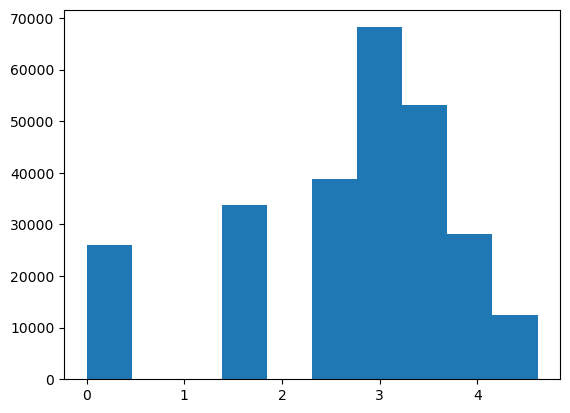

In [280]:
plt.hist(numerical_df.age)

In [282]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler, MinMaxScaler

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

In [284]:
y_train.value_counts()

damage_grade
1    103845
2     61052
0     17523
Name: count, dtype: int64

In [286]:
y_test.value_counts()

damage_grade
1    44414
2    26166
0     7601
Name: count, dtype: int64

In [288]:
from category_encoders import BaseNEncoder

In [290]:
#from src.eda_first import summarize_dataframe
#summarize_dataframe(X_train)

In [292]:
#create numerical transformer

numerical_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

#create categorical transformer
#categorical_transformer = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='most_frequent')),
#                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
#                                            ])

base_encoder_columns = ['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status']

base_encoder = Pipeline(steps=[
    ('base_encoder', BaseNEncoder(cols=base_encoder_columns, base=3))
])

In [294]:
# Combine the transformations using ColumnTransformer
#preprocessor = ColumnTransformer(transformers=[
#    ('base_name', base_encoder, base_encoder_columns)])  # TargetEncoder for 'town'
#    ('num', numerical_transformer, numerical_cols)])

In [296]:
preprocessor = ColumnTransformer(transformers=[
    ('base_name', base_encoder, base_encoder_columns),  # TargetEncoder for 'town'
    ('num', 'passthrough', numerical_cols)  # Pass numerical columns through without transformation
])

In [298]:
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
# XGBoost
xgb = XGBClassifier(
    n_estimators=339,
    learning_rate=0.2669112505018992,
    max_depth=5,
    random_state=42,
    reg_lambda=1.2259716591605452,
    subsample=0.704976942819638,
    colsample_bytree=0.9,
    min_child_weight=4,
    alpha= 0.14170716330946964,    # Added L1 regularization
    #reg_lambda=1,   # Added L2 regularization (can also be increased)
    eval_metric='aucpr'
)

rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Step 1: Preprocessing
    ('xgboost', xgb)  # Step 3: Model training
])

# Preprocessing of training data, fit model 
#rf_pipe.fit(X_train, y_train)

# Preprocessing of training data, fit model after upsampling!
rf_pipe.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
rf_preds = rf_pipe.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, rf_preds)
print('Accuracy for XGBoost:', accuracy)

# Detailed classification report
print('Classification Report:\n', classification_report(y_test, rf_preds))

Accuracy for XGBoost: 0.7329530192757832
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.48      0.57      7601
           1       0.73      0.85      0.79     44414
           2       0.75      0.61      0.67     26166

    accuracy                           0.73     78181
   macro avg       0.73      0.65      0.68     78181
weighted avg       0.73      0.73      0.73     78181



In [224]:
X_test

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,legal_ownership_status,count_families
111801,10,1224,11128,1,20,7,3,t,r,n,...,s,d,0,1,0,0,0,0,v,1
91817,22,1101,12483,2,60,7,6,t,r,n,...,s,d,0,1,0,0,0,0,v,1
251661,26,39,11440,2,50,6,5,t,r,n,...,s,d,0,0,0,0,0,0,v,1
205479,8,1073,2743,3,50,7,6,o,r,q,...,s,d,0,1,0,1,0,0,v,1
22618,6,706,7959,2,15,8,4,t,r,n,...,s,d,0,1,0,0,0,0,v,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17267,7,322,2843,2,10,6,6,t,r,n,...,s,d,1,1,0,1,0,0,v,1
66715,0,540,2361,2,20,7,5,t,r,n,...,s,d,0,1,0,1,0,0,v,1
243127,11,155,12428,2,45,8,8,t,r,n,...,s,d,0,1,0,1,0,0,v,1
2108,26,1401,8525,3,40,6,9,t,r,n,...,t,d,0,1,0,0,0,0,v,1
